<a href="https://colab.research.google.com/github/gerald-wambui/RentIn/blob/main/crop_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [02:47<00:00, 104MB/s] 
100% 14.9G/14.9G [02:47<00:00, 95.2MB/s]


In [ ]:
!unzip \*.zip


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# import system libs

import time
import shutil
import pathlib
import itertools

In [ ]:
# Ignore Warnings not executed
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
df = pd.read_csv('train.csv')
print(df)

                      image                           labels
0      800113bb65efe69e.jpg                          healthy
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2      80070f7fb5e2ccaa.jpg                             scab
3      80077517781fb94f.jpg                             scab
4      800cbf0ff87721f8.jpg                          complex
...                     ...                              ...
18627  fffb900a92289a33.jpg                          healthy
18628  fffc488fa4c0e80c.jpg                             scab
18629  fffc94e092a59086.jpg                             rust
18630  fffe105cf6808292.jpg          scab frog_eye_leaf_spot
18631  fffe472a0001bd25.jpg                          healthy

[18632 rows x 2 columns]


In [ ]:
print(pd.describe())


In [ ]:
labels = pd['labels'].unique()
for label in labels:
  print(label)

healthy
scab frog_eye_leaf_spot complex
scab
complex
rust
frog_eye_leaf_spot
powdery_mildew
scab frog_eye_leaf_spot
frog_eye_leaf_spot complex
rust frog_eye_leaf_spot
powdery_mildew complex
rust complex

In [ ]:
#skip
import random

input_dir = '/content/train_images'
output_dir = '/content/augmented_images'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [ ]:
#skip image rotation
csv_file = '/content/train.csv'
df_labels = pd.read_csv(csv_file)

def rotate_image(image, angle):
  rows, cols, _ = image.shape
  M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

  rotate_image = cv2.warpAffine(image, M, (cols, rows))
  return rotate_image

In [ ]:
#skip data augmentation
from random import randint
def horizontal_flip(image):
  return cv2.flip(image, 1)

def vertical_flip(image):
  return cv2.flip(image, 0)

def zoom_and_crop(image):
  height, width, _ = image.shape
  zoom_factor = random.uniform(1.0, 1.5)
  cropped_size = int(min(height, width)/ zoom_factor)
  x_start = random.randint(0, width - cropped_size)
  y_start = random.randint(0, height - cropped_size)
  cropped_image = image[y_start:y_start + cropped_size, x_start:x_start + cropped_size]
  return cv2.resize(cropped_image, (height, width))

for index, row in df_labels.iterrows():
  image_file = row['image']
  label = row['labels']
  image_path = os.path.join(input_dir, image_file)
  original_image = cv2.imread(image_path)

  rotated_image = rotate_image(original_image, random.randint(1, 360))
  horizontal_flipped_image = horizontal_flip(original_image)
  vertical_flipped_image = vertical_flip(original_image)
  zoomed_and_cropped_image = zoom_and_crop(original_image)

  cv2.imwrite(os.path.join(output_dir, f'rotated_{image_file}'), rotated_image)
  cv2.imwrite(os.path.join(output_dir, f'horizontal_flip_{image_file}'), horizontal_flipped_image)
  cv2.imwrite(os.path.join(output_dir, f'vertical_flip_{image_file}'), vertical_flipped_image)
  cv2.imwrite(os.path.join(output_dir, f'zoomed_and_cropped_{image_file}'), zoomed_and_cropped_image)

  with open(os.path.join(output_dir, 'augmented.csv'), 'a') as f:
    f.write(f'{image_file}:{label}\n')



In [ ]:
# Function to generate data paths with labels
def split_df(csv_dir):
    df = pd.read_csv(csv_dir)

    # train dataframe
    train_df, dummy_df = train_test_split(df,
                                          train_size= 0.7,
                                          shuffle= True,
                                          random_state= 123
                                          )

    # valid and test dataframe
    valid_df, test_df = train_test_split(dummy_df,
                                         train_size= 0.5,
                                         shuffle= True,
                                         random_state= 123
                                         )

    return train_df, valid_df, test_df

In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):

    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes
        data from image data generator.
        Image data generator converts images into tensors.
        Check your variables'''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    #img_shape = (224, 224, 3)
    train_dir = '/content/train_images'
    test_dir = '/content/test_images'
    fpath_col = 'image'
    label_col = 'labels'

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                                horizontal_flip= True
                                )
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df,
                                           directory= train_dir,
                                            x_col= fpath_col,
                                            y_col= label_col,
                                            target_size= img_size,
                                            class_mode= 'categorical',
                                            color_mode= color,
                                            shuffle= True,
                                            batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df,
                                           directory= train_dir,
                                           x_col= fpath_col,
                                           y_col= label_col,
                                           target_size= img_size,
                                           class_mode= 'categorical',
                                           color_mode= color,
                                           shuffle= True,
                                           batch_size= batch_size
                                            )

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df,
                                           directory= train_dir,
                                           x_col= fpath_col,
                                           y_col= label_col,
                                           target_size= img_size,
                                           class_mode= 'categorical',
                                           color_mode= color,
                                           shuffle= False,
                                           batch_size= test_batch_size
                                           )

    return train_gen, valid_gen, test_gen

In [ ]:
def show_images(df, data_path):
    sample_df = df.sample(16)
    image_names = sample_df["image"].values
    labels = sample_df["labels"].values
    plt.figure(figsize=(16, 12))

    for image_ind, (image_name, label) in enumerate(zip(image_names, labels)):
        plt.subplot(4, 4, image_ind + 1)
        image = cv2.imread(os.path.join(data_path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    plt.show()

In [ ]:
def plot_labels(df):
    '''
    This function take df and plot labels value counts
    '''

    plt.figure(figsize= (12, 8))
    labels = sns.barplot(x= df.labels.value_counts().index, y= df.labels.value_counts())
    for item in labels.get_xticklabels():
        item.set_rotation(45)

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

 # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)

def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')

def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')



In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()



In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)


	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [ ]:
csv_dir = '/content/train.csv'
train_path = '/content/train_images'
try:
    # Get splitted data
    train_df, valid_df, test_df = split_df(csv_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception:
    print('Invalid Input')

Found 13042 validated image filenames belonging to 12 classes.
Found 2795 validated image filenames belonging to 12 classes.
Found 2795 validated image filenames belonging to 12 classes.


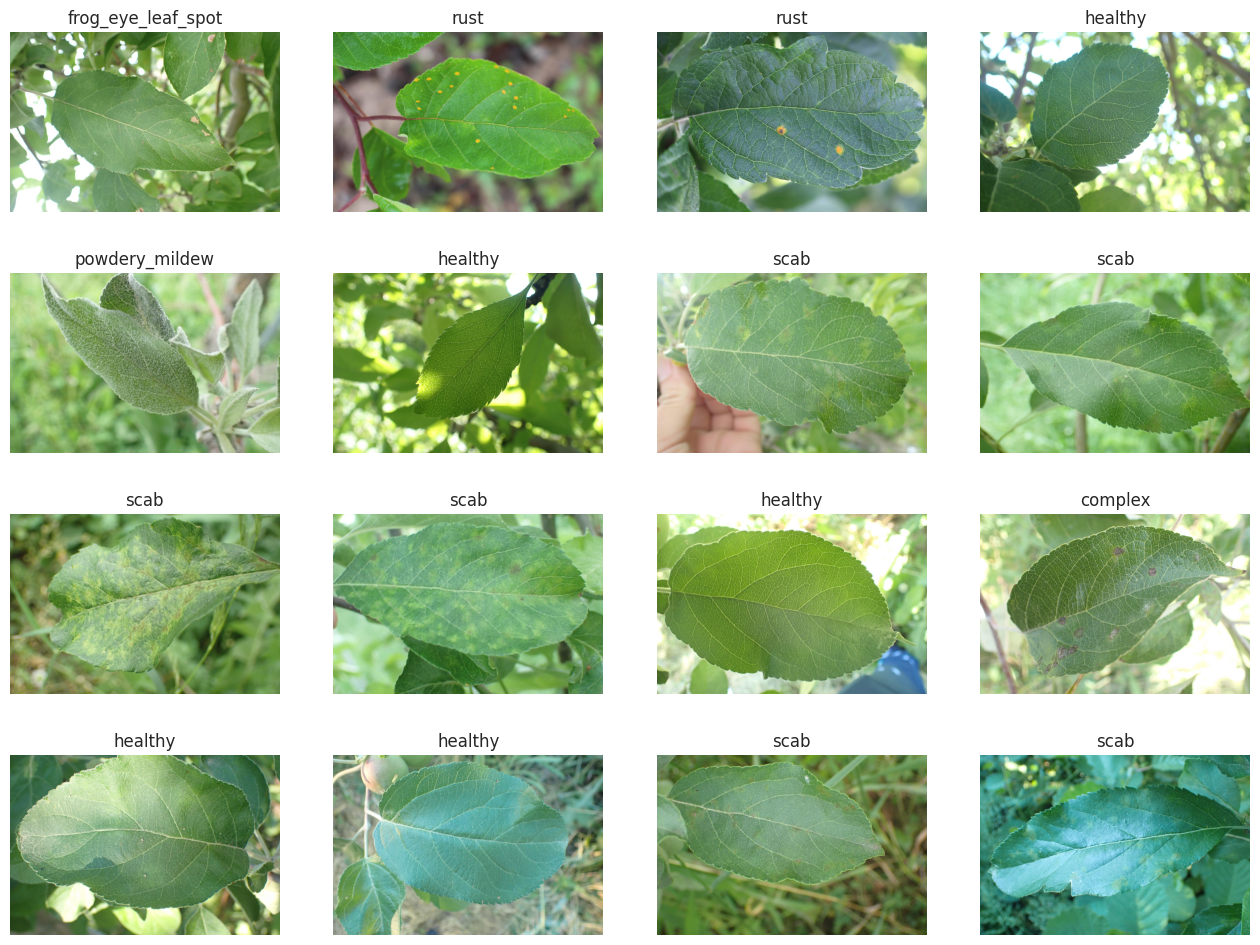

In [ ]:
show_images(train_df, train_path)

In [ ]:
plot_labels(train_df)

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False,
                                                               weights= "imagenet",
                                                               input_shape= img_shape,
                                                               pooling= 'max')
model = Sequential([
    base_model,


    Dense(512, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation='relu'),
    BatchNormalization(),

    Dense(200, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    BatchNormalization(),

    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation='relu'),
    BatchNormalization(),
    Dense(64, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.3, seed= 123),
    Dense(class_count, activation= 'softmax')
])


In [ ]:
model.compile(Adam(learning_rate= 0.1), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


In [ ]:
batch_size = 500
epochs = 50
patience = 2
stop_patience = 3
threshold = 0.9
factor = 0.5
ask_epoch = 1
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [ ]:
history = model.fit(train_gen,
                    epochs = 20,
                    verbose= 1,
                    validation_data = valid_gen,
                    validation_steps = None,
                    steps_per_epoch=200
                    #callbacks = callbacks
                    )

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

43/43 [==============================] - 179s 4s/step - loss: 0.8210 - accuracy: 0.8261
Train Loss:  0.7339332699775696
Train Accuracy:  0.8511627912521362
--------------------
Validation Loss:  0.7865421772003174
Validation Accuracy:  0.8430232405662537
--------------------
Test Loss:  0.8209707736968994
Test Accuracy:  0.8261180520057678


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'ApplePathology'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

In [ ]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved Keras model from the .h5 file
model = tf.keras.models.load_model('/content/efficientnetb3-ApplePathology-88.59.h5')


In [ ]:

# Load and preprocess the image
image_path = '/content/test_images/c7b03e718489f3ca.jpg'  # Replace with the path to your image
img = image.load_img(image_path, target_size=(224, 224))  # Adjust target_size to match your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Preprocess according to the model's requirements

# Perform prediction
predictions = model.predict(img_array)

# The 'predictions' variable now contains the model's output
# You can interpret the predictions based on your model's task.
# For example, if it's a classification task, you can find the class with the highest probability:
predicted_class_index = np.argmax(predictions)
print(predicted_class_index)


1/1 [==============================] - 0s 33ms/step
6


Conversion to tflite

In [ ]:
from tensorflow import lite
# Load your trained model
model = tf.keras.models.load_model('/content/efficientnetb3-ApplePlantPathology-88.59.h5')

# Create a TFLite converter instance
converter = lite.TFLiteConverter.from_keras_model(model)

# Set the optimization flag for quantization (INT8)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Specify that you want to use INT8 quantization
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the quantized model to a TFLite file
with open('quantized_gerald_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import lite
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='/content/quantized_gerald_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the input image
image_path = '/content/85f8cb619c66b863 (1).jpg'
image = Image.open(image_path)
image = image.resize((input_details[0]['shape'][2], input_details[0]['shape'][2]))
image = np.array(image) / 255
image = image.astype(np.float32)  # Convert to float32
image = np.expand_dims(image, axis=0)


# Perform inference
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the output data as needed
# output_data contains the model's predictions
print(output_data)


[[0.3460998  0.52134067 0.3245416  0.77825254 0.4856634  0.1081743
  0.83487695 0.22404072 0.53038055 0.73436236 0.05123315 0.11362539]]


In [ ]:
# Assuming `output_data` contains the model's predictions (classification probabilities)
class_labels = ['complex', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot complex', 'healthy', 'powdery_mildew', 'powdery_mildew complex', 'rust', 'rust complex', 'rust frog_eye_leaf_spot', 'scab', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot complex']  # Replace with your actual class labels

# Find the index of the class with the highest probability
predicted_class_index = np.argmax(output_data)

# Get the label associated with the predicted class
predicted_label = class_labels[predicted_class_index]

# Output the predicted label
print(f"Predicted Label: {predicted_label}")
print(predicted_class_index)


Predicted Label: rust
6
